In [15]:
from src.toy_functions import ResponseFunction, six_curve_sum
import torch
from ax import Client, RangeParameterConfig

from torch._tensor import Tensor
import importlib


from botorch.models import SingleTaskGP
import math
import importlib

from src import GPVisualiser, ax_helper
from botorch.models import SingleTaskGP
importlib.reload(GPVisualiser)


<module 'src.GPVisualiser' from 'c:\\GitHub\\BO-Coli\\src\\GPVisualiser.py'>

In [16]:
dim_names = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6']
simple_func = lambda x: sum(torch.sqrt(x))
resp = ResponseFunction(simple_func, len(dim_names))
resp.evaluate(torch.tensor([1., 4., 9., 16., 25., 36.]))

tensor(21.)

In [17]:
from typing import Literal
import pandas as pd
import seaborn as sns


from src.ax_helper import get_guess_coords

# Sobol
The default initial parameter exploration strategy uses SOBOL algorithm:

### log param sobol:

[INFO 09-21 09:58:34] ax.api.client: GenerationStrategy(name='Center+Sobol+MBM:fast', nodes=[CenterGenerationNode(next_node_name='Sobol'), GenerationNode(node_name='Sobol', generator_specs=[GeneratorSpec(generator_enum=Sobol, model_key_override=None)], transition_criteria=[MinTrials(transition_to='MBM'), MinTrials(transition_to='MBM')]), GenerationNode(node_name='MBM', generator_specs=[GeneratorSpec(generator_enum=BoTorch, model_key_override=None)], transition_criteria=[])]) chosen based on user input and problem structure.
[INFO 09-21 09:58:34] ax.api.client: Generated new trial 0 with parameters {'x0': 10.0, 'x1': 10.0, 'x2': 10.0, 'x3': 10.0, 'x4': 10.0, 'x5': 10.0} using GenerationNode CenterOfSearchSpace.
[INFO 09-21 09:58:34] ax.api.client: Generated new trial 1 with parameters {'x0': 25.630086, 'x1': 12.286456, 'x2': 1.353386, 'x3': 10.911617, 'x4': 2.601117, 'x5': 56.19076} using GenerationNode Sobol.
[INFO 09-21 09:58:34] ax.api.client: Generated new trial 2 with parameters {'

   trial_name         x0         x1         x2         x3         x4  \
0         0_0  10.000000  10.000000  10.000000  10.000000  10.000000   
1         1_0  25.630086  12.286456   1.353386  10.911617   2.601117   
2         2_0   6.639213   1.844502  98.793614   4.954591  22.805201   
3         3_0   2.287618  40.984651   3.206117  34.340891  46.945394   
4         4_0  79.743160   6.385386  23.400506   1.560289   3.995764   
5         5_0  37.016322  84.021307  49.719774   2.769141   9.209769   
6         6_0   1.476757   5.538857   2.672824  61.187207  60.004310   
7         7_0   4.416118  25.159908  11.802438   8.788509  16.466646   
8         8_0  13.329854   1.601781   6.345613  19.453316   1.061273   
9         9_0  15.930050  46.963975  16.312439  92.513041  26.484238   
10       10_0   3.431011   9.394018   8.160412   2.035567   2.321835   
11       11_0   1.068879  13.550999  38.635361  29.362175   4.777908   
12       12_0  55.080844   2.819341   1.933030   6.471930  40.69

<Axes: xlabel='x0', ylabel='x1'>

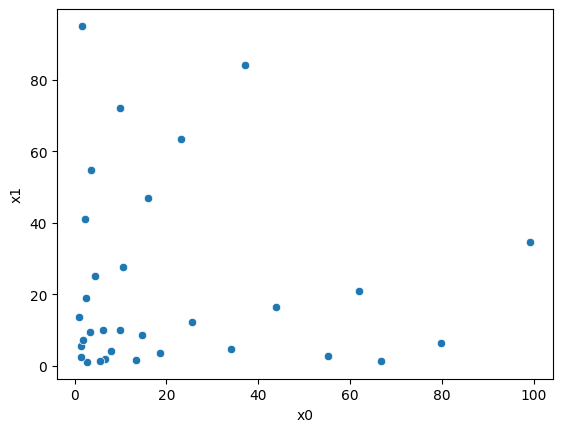

In [18]:
client = Client()

client.configure_experiment(
    name="batch_bo_test",
    parameters=[
        RangeParameterConfig(
            name=f"x{i}",
            bounds=(1, 100),
            parameter_type="float",
            scaling = 'log',
        ) for i in range(len(dim_names))
    ],
)


client.configure_optimization(objective="-loss")

client.get_next_trials(max_trials=32)

coords = get_guess_coords(client)
print(coords)
sns.scatterplot(data=coords, x="x0", y="x1")

Low value oversampling is inline with logarithmic distribution.

**Considering that we expect overexpression to be optimal when compared to underexpression, Sobol should be run on a linear scale**.

### linear parameters sobol

[INFO 09-21 09:58:34] ax.api.client: GenerationStrategy(name='Center+Sobol+MBM:fast', nodes=[CenterGenerationNode(next_node_name='Sobol'), GenerationNode(node_name='Sobol', generator_specs=[GeneratorSpec(generator_enum=Sobol, model_key_override=None)], transition_criteria=[MinTrials(transition_to='MBM'), MinTrials(transition_to='MBM')]), GenerationNode(node_name='MBM', generator_specs=[GeneratorSpec(generator_enum=BoTorch, model_key_override=None)], transition_criteria=[])]) chosen based on user input and problem structure.
[INFO 09-21 09:58:34] ax.api.client: Generated new trial 0 with parameters {'x1': 50.5, 'x2': 50.5, 'x3': 50.5, 'x4': 50.5, 'x5': 50.5, 'x6': 50.5} using GenerationNode CenterOfSearchSpace.
[INFO 09-21 09:58:34] ax.api.client: Generated new trial 1 with parameters {'x1': 48.489763, 'x2': 13.721, 'x3': 96.867883, 'x4': 49.654371, 'x5': 67.933831, 'x6': 77.794238} using GenerationNode Sobol.
[INFO 09-21 09:58:34] ax.api.client: Generated new trial 2 with parameters {'

  trial_name         x1         x2         x3         x4         x5         x6
0        0_0  50.500000  50.500000  50.500000  50.500000  50.500000  50.500000
1        1_0  48.489763  13.721000  96.867883  49.654371  67.933831  77.794238
2        2_0  80.423653  91.004534  16.905745  61.646222  49.973666  17.208644
3        3_0  52.972740  32.038954  68.714565   4.337069  17.965012  27.610509
4        4_0  20.253601  59.822111  45.035316  91.352770  97.065211  67.398450
5        5_0   7.748846  39.476984  11.200152  87.279720  84.739960  92.111696
6        6_0  65.530672  67.187596  77.050061  25.015517   5.346698   2.897209
7        7_0  92.982023   8.675260  26.764370  66.902750  37.448999  41.898146
8        8_0  35.985421  85.886250  61.462097  30.162421  55.901625  53.104776
9        9_0  27.870500  31.394065  34.634853  14.002910  42.578997  72.815259


<Axes: xlabel='x1', ylabel='x2'>

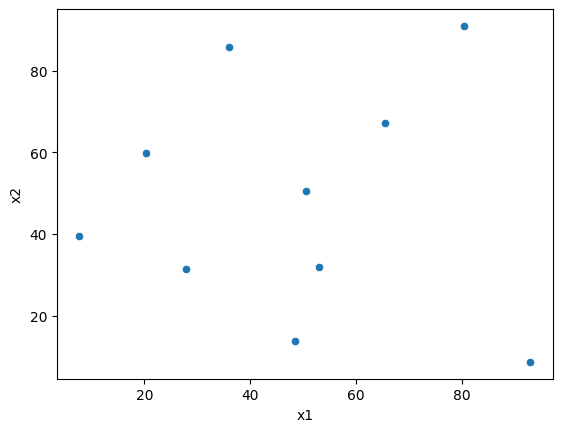

In [19]:


client = Client()

parameters=[
    RangeParameterConfig(
        name=dim,
        bounds=(1, 100),
        parameter_type="float",
        # scaling = 'log',
    ) for dim in dim_names
]


client.configure_experiment(
    name="batch_bo_test",
    parameters=parameters
)


client.configure_optimization(objective="response")

client.get_next_trials(max_trials=10)




for i, trial in ax_helper.get_obs_from_client(client, response_col='response').iterrows():
    if not pd.isna(trial['response']):
        continue

    response = resp.evaluate(trial[dim_names])
    client.complete_trial(trial_index=i, raw_data={"response": float(response)})

coords = get_guess_coords(client)
print(coords)
sns.scatterplot(data=coords, x="x1", y="x2")

A nice and informative initial guess grid is formed

[INFO 09-21 09:58:35] ax.api.client: Generated new trial 10 with parameters {'x1': 46.28336, 'x2': 95.436399, 'x3': 72.578217, 'x4': 76.93467, 'x5': 85.089931, 'x6': 41.818545} using GenerationNode MBM.
[WARNING 09-21 09:58:35] ax.api.client: 6 trials requested but only 1 could be generated.
C:\Users\326po\AppData\Local\Temp\ipykernel_24780\767171169.py:19: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



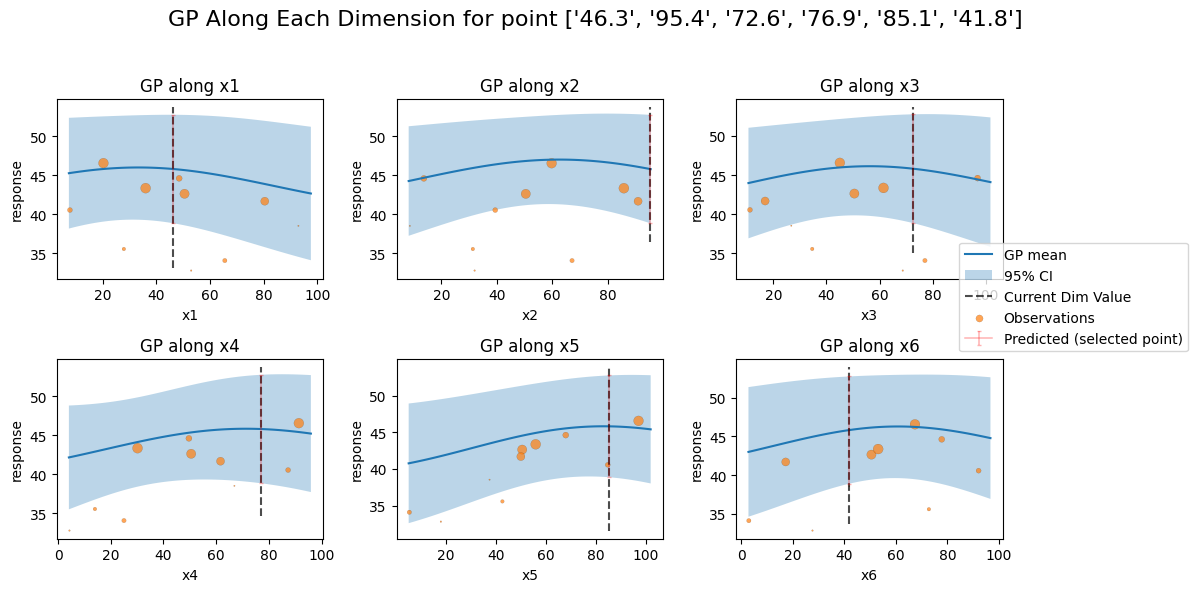

In [20]:


for i, trial in ax_helper.get_obs_from_client(client, response_col='response').iterrows():
    if not pd.isna(trial['response']):
        continue

    response = resp.evaluate(trial[dim_names])
    client.complete_trial(trial_index=i, raw_data={"response": float(response)})

client.get_next_trials(max_trials=6)

obs = ax_helper.get_obs_from_client(client, response_col='response')
plotter = GPVisualiser.GPVisualiserMatplotlib(SingleTaskGP, obs, dim_names, 'response', parameters)


for i, trial in obs.iterrows():
    if pd.isna(trial['response']):

        coords = trial.loc[dim_names]

        plotter.plot_all(torch.tensor(coords))




(<Figure size 1200x600 with 6 Axes>,
 array([<Axes: title={'center': 'GP along x1'}, xlabel='x1', ylabel='response'>,
        <Axes: title={'center': 'GP along x2'}, xlabel='x2', ylabel='response'>,
        <Axes: title={'center': 'GP along x3'}, xlabel='x3', ylabel='response'>,
        <Axes: title={'center': 'GP along x4'}, xlabel='x4', ylabel='response'>,
        <Axes: title={'center': 'GP along x5'}, xlabel='x5', ylabel='response'>,
        <Axes: title={'center': 'GP along x6'}, xlabel='x6', ylabel='response'>],
       dtype=object))

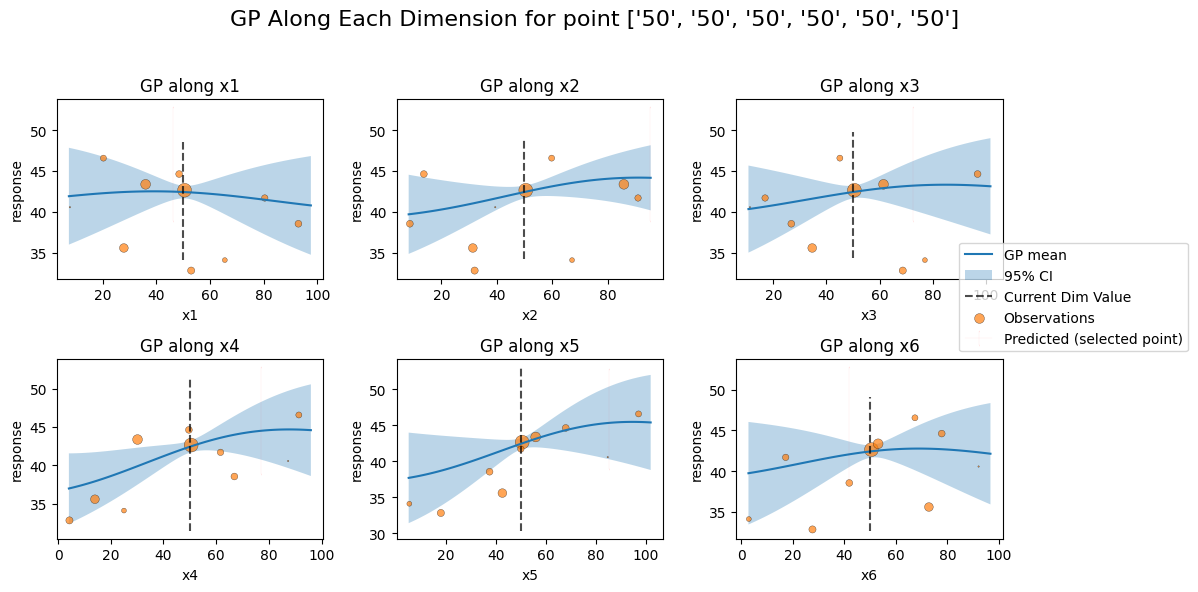

In [21]:
obs = ax_helper.get_obs_from_client(client, response_col='response')
plotter = GPVisualiser.GPVisualiserMatplotlib(SingleTaskGP, obs, dim_names, 'response', parameters)
plotter.plot_all([50,50,50,50,50,50])

In [22]:
obs

,trial_name,x1,x2,x3,x4,x5,x6,response
0,0_0,50.500000,50.500000,50.500000,50.500000,50.500000,50.500000,42.638011
1,1_0,48.489763,13.721000,96.867883,49.654371,67.933831,77.794238,44.618682
2,2_0,80.423653,91.004534,16.905745,61.646222,49.973666,17.208644,41.688259
3,3_0,52.972740,32.038954,68.714565,4.337069,17.965012,27.610509,32.803607
4,4_0,20.253601,59.822111,45.035316,91.352770,97.065211,67.398450,46.565399
5,5_0,7.748846,39.476984,11.200152,87.279720,84.739960,92.111696,40.558685
6,6_0,65.530672,67.187596,77.050061,25.015517,5.346698,2.897209,34.085686
7,7_0,92.982023,8.675260,26.764370,66.902750,37.448999,41.898146,38.533374
8,8_0,35.985421,85.886250,61.462097,30.162421,55.901625,53.104776,43.362119
9,9_0,27.870500,31.394065,34.634853,14.002910,42.578997,72.815259,35.567921


# Custom Botorch model

break

<Axes: >

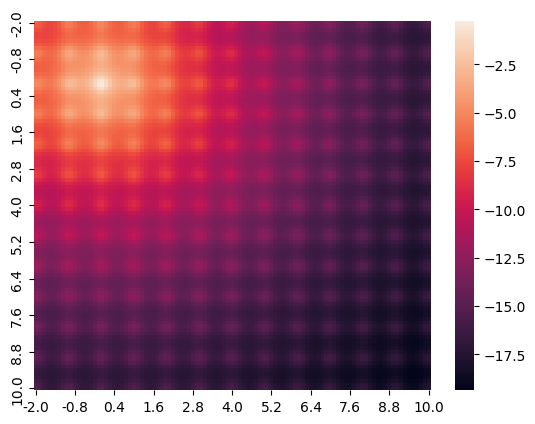

In [23]:
range_parameters = [
    RangeParameterConfig(
        name="x1", parameter_type="float", bounds=(-2, 10)
    ),
    RangeParameterConfig(
        name="x2", parameter_type="float", bounds=(-2, 10)
    )
]


def test_function(x1, x2):
    # Ackley function (commonly used for optimization benchmarks)
    a = 20
    b = 0.2
    c = 2 * math.pi
    sum_sq = 0.5 * (x1**2 + x2**2)
    cos_comp = 0.5 * (math.cos(c * x1) + math.cos(c * x2))
    ackley_grid = -a * math.exp(-b * math.sqrt(sum_sq)) - math.exp(cos_comp) + a + math.exp(1)
    return -ackley_grid


import numpy as np
grid = np.linspace(-2, 10, 101)
x1_grid, x2_grid = np.meshgrid(grid, grid)
ackley_vals = np.array([test_function(x1, x2) for x1, x2 in zip(x1_grid.ravel(), x2_grid.ravel())]).reshape(x1_grid.shape)
sns.heatmap(
    pd.DataFrame(ackley_vals, index=np.round(grid, 2), columns=np.round(grid, 2)),
    xticklabels=10,
    yticklabels=10
)


In [24]:
from ax.adapter.registry import Generators
from ax.generation_strategy.generator_spec import GeneratorSpec
from ax.api.client import Client

from src.ax_helper import construct_generation_strategy

### Define the GP surrogate


MES (max value entropy search) should be the ideal choice for acquisition functions because:
* It can handle noise.
* Samples in a manner to best define the optimum.
    * Consequently, will rarely repeat exactly identical samplings.
* Has a cost/fidelity setting

In [25]:

from botorch.models import SingleTaskGP
from botorch.acquisition import qLogExpectedImprovement, qMaxValueEntropy

from gpytorch.kernels import MaternKernel
from botorch.models import SingleTaskGP
from ax.generators.torch.botorch_modular.surrogate import SurrogateSpec, ModelConfig

surrogate_spec = SurrogateSpec(
    model_configs=[
        ModelConfig(
            botorch_model_class=SingleTaskGP,
        ),
    ]
)

generator_spec = GeneratorSpec(
    generator_enum=Generators.BOTORCH_MODULAR,
    model_kwargs={
        "surrogate_spec": surrogate_spec,
        "botorch_acqf_class": qLogExpectedImprovement,
        # Can be used for additional inputs that are not constructed
        # by default in Ax. We will demonstrate below.
        "acquisition_options": {},
    },
    # We can specify various options for the optimizer here.
    model_gen_kwargs = {
        "model_gen_options": {
            "optimizer_kwargs": {
                "num_restarts": 20,
                "sequential": False,
                "options": {
                    "batch_limit": 5,
                    "maxiter": 200,
                },
            },
        },
    }
)


generation_strategy = construct_generation_strategy(
    generator_spec=generator_spec,
    node_name="Single task, LogEI",
)

generation_strategy

GenerationStrategy(name='Center+Sobol+Single task, LogEI', nodes=[CenterGenerationNode(next_node_name='Sobol'), GenerationNode(node_name='Sobol', generator_specs=[GeneratorSpec(generator_enum=Sobol, model_key_override=None)], transition_criteria=[MinTrials(transition_to='Single task, LogEI')]), GenerationNode(node_name='Single task, LogEI', generator_specs=[GeneratorSpec(generator_enum=BoTorch, model_key_override=None)], transition_criteria=[])])

Generat

In [26]:
client = Client()


client.configure_experiment(parameters=range_parameters)

metric_name = "response"
dim_names = ["x1", "x2"]

client.set_generation_strategy(
    generation_strategy=generation_strategy,
)

client.configure_optimization(objective=metric_name)

from src import ax_helper
importlib.reload(ax_helper)

batch_handler = ax_helper.BatchClientHandler(client, test_function, dim_names, metric_name, batch_size=6, range_params=range_parameters)
batch_handler.get_next_batch()
batch_handler.complete_all_pending()

[INFO 09-21 09:58:36] ax.api.client: Generated new trial 0 with parameters {'x1': 4.0, 'x2': 4.0} using GenerationNode CenterOfSearchSpace.
[INFO 09-21 09:58:36] ax.api.client: Generated new trial 1 with parameters {'x1': 9.004676, 'x2': 8.501933} using GenerationNode Sobol.
[INFO 09-21 09:58:36] ax.api.client: Generated new trial 2 with parameters {'x1': 3.870098, 'x2': 0.742841} using GenerationNode Sobol.
[INFO 09-21 09:58:36] ax.api.client: Generated new trial 3 with parameters {'x1': -1.26009, 'x2': 6.970539} using GenerationNode Sobol.
[INFO 09-21 09:58:36] ax.api.client: Generated new trial 4 with parameters {'x1': 5.134951, 'x2': 2.773564} using GenerationNode Sobol.
[INFO 09-21 09:58:36] ax.api.client: Generated new trial 5 with parameters {'x1': 6.39676, 'x2': 4.782714} using GenerationNode Sobol.
[INFO 09-21 09:58:36] ax.api.client: Trial 0 marked COMPLETED.
[INFO 09-21 09:58:36] ax.api.client: Trial 1 marked COMPLETED.
[INFO 09-21 09:58:36] ax.api.client: Trial 2 marked COM

[INFO 09-21 09:58:40] ax.api.client: Generated new trial 6 with parameters {'x1': 2.691111, 'x2': -2.0} using GenerationNode Single task, LogEI.
[INFO 09-21 09:58:40] ax.api.client: Generated new trial 7 with parameters {'x1': 1.810714, 'x2': -2.0} using GenerationNode Single task, LogEI.
[INFO 09-21 09:58:40] ax.api.client: Generated new trial 8 with parameters {'x1': 3.407775, 'x2': -2.0} using GenerationNode Single task, LogEI.
[INFO 09-21 09:58:40] ax.api.client: Generated new trial 9 with parameters {'x1': 2.468438, 'x2': 0.903903} using GenerationNode Single task, LogEI.
[INFO 09-21 09:58:40] ax.api.client: Generated new trial 10 with parameters {'x1': 1.022983, 'x2': -2.0} using GenerationNode Single task, LogEI.
[INFO 09-21 09:58:40] ax.api.client: Generated new trial 11 with parameters {'x1': 1.940934, 'x2': 6.838315} using GenerationNode Single task, LogEI.
[INFO 09-21 09:58:40] ax.api.client: Trial 6 marked COMPLETED.
[INFO 09-21 09:58:40] ax.api.client: Trial 7 marked COMPL

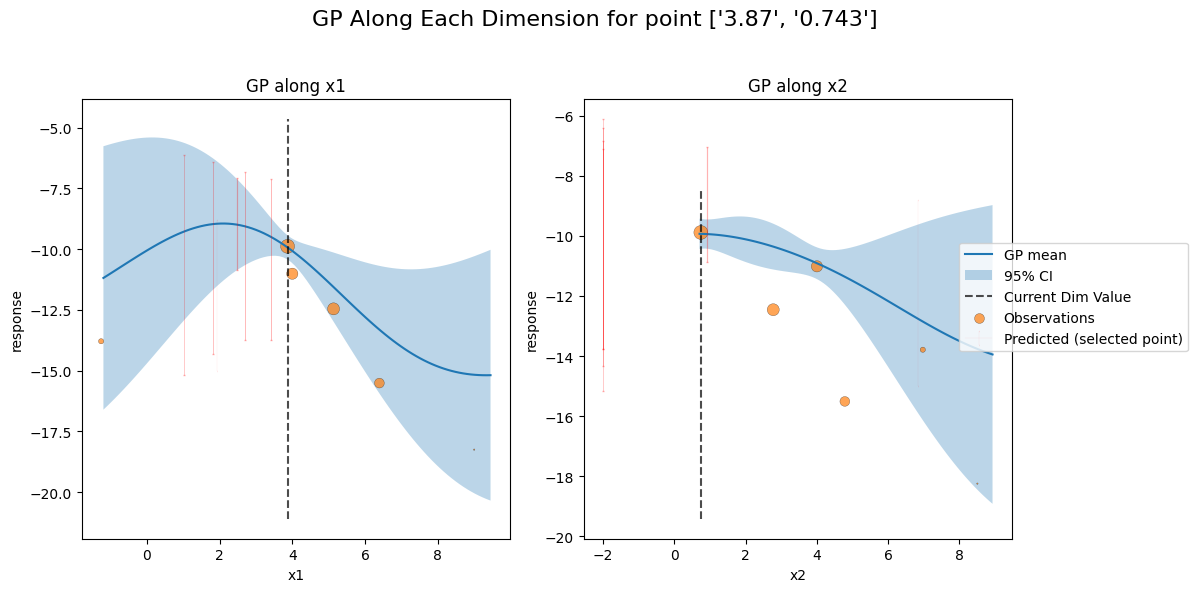

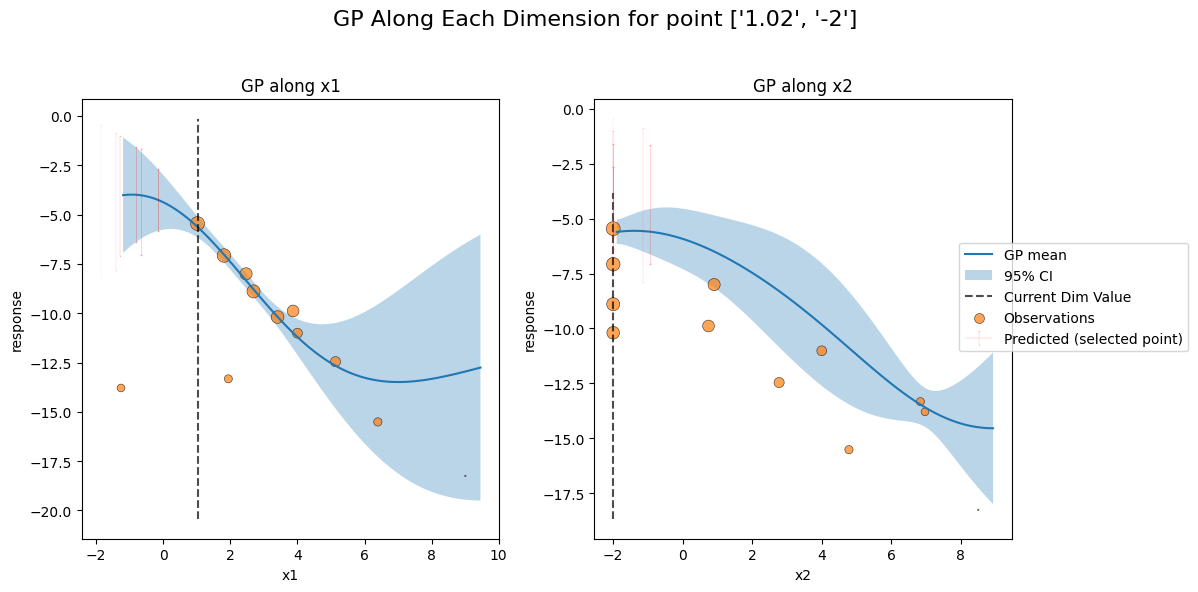

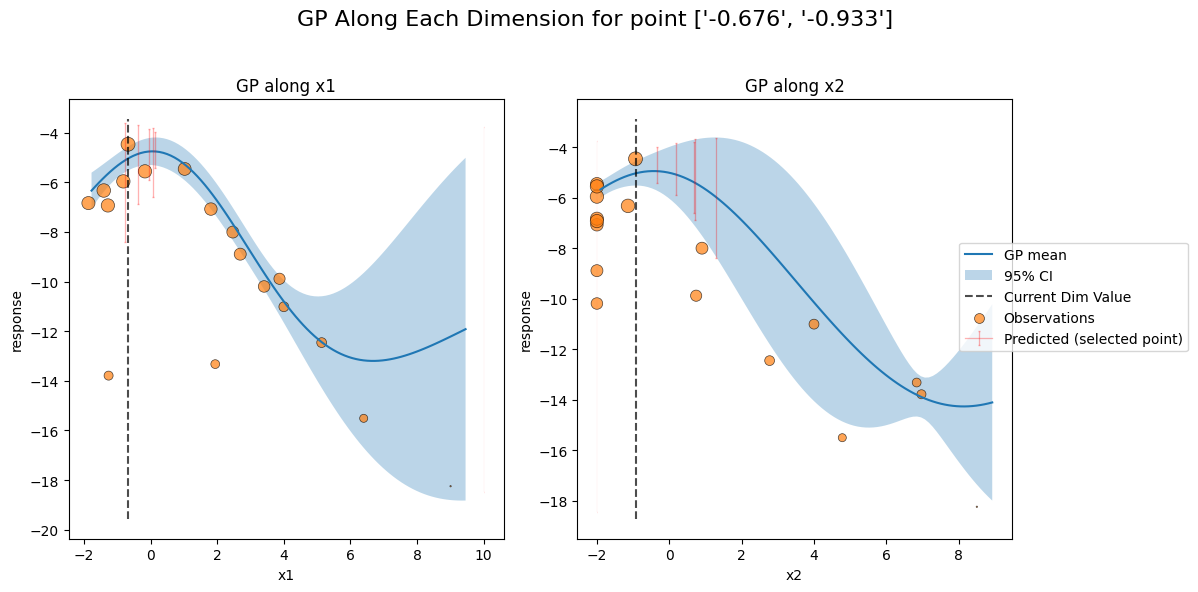

In [27]:
for _ in range(3):
    batch_handler.get_next_batch()
    batch_handler.plot_GP(SingleTaskGP)
    batch_handler.complete_all_pending()

In [28]:
obs

,trial_name,x1,x2,x3,x4,x5,x6,response
0,0_0,50.500000,50.500000,50.500000,50.500000,50.500000,50.500000,42.638011
1,1_0,48.489763,13.721000,96.867883,49.654371,67.933831,77.794238,44.618682
2,2_0,80.423653,91.004534,16.905745,61.646222,49.973666,17.208644,41.688259
3,3_0,52.972740,32.038954,68.714565,4.337069,17.965012,27.610509,32.803607
4,4_0,20.253601,59.822111,45.035316,91.352770,97.065211,67.398450,46.565399
5,5_0,7.748846,39.476984,11.200152,87.279720,84.739960,92.111696,40.558685
6,6_0,65.530672,67.187596,77.050061,25.015517,5.346698,2.897209,34.085686
7,7_0,92.982023,8.675260,26.764370,66.902750,37.448999,41.898146,38.533374
8,8_0,35.985421,85.886250,61.462097,30.162421,55.901625,53.104776,43.362119
9,9_0,27.870500,31.394065,34.634853,14.002910,42.578997,72.815259,35.567921
